### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.0.1+cu118


### MNIST dataset is provided from Google Colab by default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in mnist_reader:
            img = np.array(row[1:], dtype=np.uint8).reshape(img_size, img_size)
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)

    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

# Let's try to reduce the number of data we have, for faster experiment
# stride = 100
# train_img = train_img[::stride]
# train_label = train_label[::stride]
# test_img = test_img[::stride]
# test_label = test_label[::stride]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, img, label):
        self.img = img
        self.label = label
        self.num_data = self.img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()

        sample['img'] = self.img[idx] / 255
        sample['label'] = self.label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
test_dataset = MNIST_Dataset(test_img, test_label)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(test_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)
print(sample['label'])

torch.Size([64, 28, 28])
torch.Size([64])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


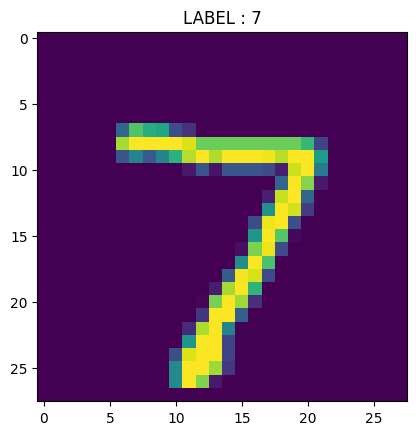

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### You may add transforms from torchvision, for data augmentation.
### Below is just a simple example doing a affine transform

In [ ]:
custom_transforms = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.75)
])

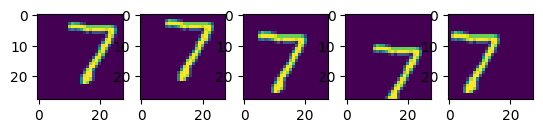

In [ ]:
num_plots = 5
fig, ax = plt.subplots(1, num_plots)

for a in ax:
    trans_img = custom_transforms(sample['img'][0].unsqueeze(0))
    a.imshow(trans_img.squeeze())

### Define the Multiple Layer Perceptrons

In [ ]:
class MyModel(nn.Module):
    def __init__(self, dim_hid_1=128, dim_hid_2=128, dim_inp=img_size**2, dim_out=10):
        super(MyModel, self).__init__()

        self.dim_hid_1 = dim_hid_1
        self.dim_hid_2 = dim_hid_2
        self.dim_inp = dim_inp
        self.dim_out = dim_out

        self.acti = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.block_1 = nn.Sequential(nn.Linear(dim_inp, dim_hid_1),
                                     self.acti,
                                     self.dropout,
                                     )
        self.block_2 = nn.Sequential(nn.Linear(dim_hid_1, dim_hid_2),
                                     self.acti,
                                     self.dropout,
                                     )
        self.final_layer = nn.Linear(dim_hid_2, dim_out)

    def forward(self, img):
        batch_size = img.shape[0]
        inp = img.view(batch_size, -1)

        out = self.block_1(inp)
        out = self.block_2(out)
        out = self.final_layer(out)

        return out

### Define the Model and its optimizer

In [ ]:
model = MyModel()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

MyModel(
  (acti): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (block_1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (block_2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (final_layer): Linear(in_features=128, out_features=10, bias=True)
)


### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    # set model to 'train' mode
    model.train()

    # define loss function
    criterion = nn.CrossEntropyLoss()

    # define input and output
    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device)

    # get prediction
    pred = model(img)

    # count number of correct answers from training dataset
    num_correct = sum(torch.argmax(pred, dim=1) == label)

    # calculate the loss
    pred_loss = criterion(pred, label)

    # run 1-step training iteration
    optimizer.zero_grad()
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    # set model to 'evalaution' mode
    model.eval()

    # define loss function
    criterion = nn.CrossEntropyLoss()

    # define input and output
    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device)

    # declare that you don't want to calculate the gradient automatically with "no_grad"
    with torch.no_grad():
        # get prediction
        pred = model(img)

        # calcualte the loss
        pred_loss = criterion(pred, label)

        # count the number of correct answers from test dataset
        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
max_epoch = 100
print_stride = 10

tr_loss_saver = []
te_loss_saver = []

for epoch in tqdm(range(max_epoch)):
    ###Train Phase

    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    tr_loss_saver.append(train_loss)
    torch.save(model.state_dict(), 'recent.pth')

    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)

    te_loss_saver.append(test_loss)

    if (epoch+1) % print_stride == 0:
        print('[epoch {}] train accu :{:.2f} , test accu :{:.2f}'.format(epoch+1, train_accu, test_accu))

  0%|          | 0/100 [00:00<?, ?it/s]

[epoch 10] train accu :0.88 , test accu :0.92
[epoch 20] train accu :0.92 , test accu :0.94


KeyboardInterrupt: ignored

### Plot the train and test loss for checking the overfitting.

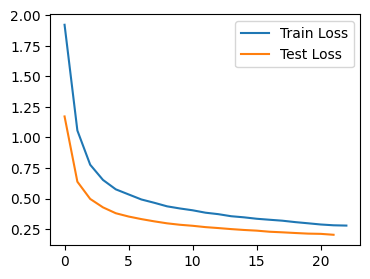

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(tr_loss_saver)
plt.plot(te_loss_saver)
plt.legend(['Train Loss', 'Test Loss'])